# What's EDA about?

For a Data Science project with a predefine clear goal, an EDA (Exploratory Data Analysis) can helps to understand particular aspects and distributions of the data, then clean and pre-process it accordingly for a model-ready dataset. 
On the other hand, if there's not a clear goal stablished in the project, the advanced EDA can be used to add insights about hidden correlations within the data through plots and a deep analysis with a specific angle.

# Context

This notebook shows an EDA on an dataset used for an investigation into speed disparities in internet service offers. The data collected is more than 1 million address-specific offers across dozens of US cities from 4 ISP's (Internet Service Providers). To support the findings, they’ve shared the raw data gathered from ISPs’ websites, as well as tabular files that summarize each offer and attach the contextual variables used for the analysis.

The internet offers are categorised by speed, and the receiving area’s race and ethnicity, income, and historic HOLC (Home Owners' Loan Corporation) grades.

1. <ins>Speeds</ins>: **Slow** (below 25 Mbps download speed), **Medium** (at or above 25 and less than 100 Mbps), **Fast** (at or above 100 and less than 200 Mbps) and **Blazing** (at or above 200 Mbps download speed).

2. <ins>Income</ins>: within each city the addresses are categorized by income using quartiles (“lower,” “middle-lower,” “middle-upper,” “upper”) based on the *median household income* of an address’s block group.  

3. <ins>Race and Ethnicity</ins>: within each city the addresses are categorized by race and ethnicity using quartiles (”least White,” “less White,” “more White,” “most White”) based on the *percentage of residents* identifying as non-Hispanic White in the address’s block group.  

4. <ins>Redlined Areas</ins>: the phrase “redlining” is associated with D-rated areas, which HOLC deemed too **hazardous** to secure loans. Most households were rated by the HOLC to be in C or **declining** areas. Fewer houses were in **desirable** areas, with a B rating, and even fewer in **best”** areas, rated A.

More info about the scope of this research: [How We Uncovered Disparities in Internet Deals](https://themarkup.org/show-your-work/2022/10/19/how-we-uncovered-disparities-in-internet-deals)

# Dataset

The dataset consists of four CSV files where each file contains a different ISPS: AT&T, Earthlink, Centurylink, and Verizon. The following table contains descriptions of the main features before processing the data.

| Column                        | Description                                                                                                                                  | 
| :---                          | :---                                                                                                                                         | 
| `address_full`                | The complete postal address of a household we searched.                                                                                      | 
| `incorporated_place`          | The incorporated city that the address belongs to.                                                                                           |
| `major_city`                  | The city that the address is in.                                                                                                             |
| `state`                       | The state that the address is in.                                                                                                            |
| `lat`                         | The address’s latitude. From OpenAddresses or NYC Open Data.                                                                                 |
| `lon`                         | The address’s longitude. From OpenAddresses or NYC Open Data.                                                                                |
| `block_group`                 | The Census block group of the address, as of 2019. From the Census Geocoder API based on `lat` and `lon`.                                    |
| `collection_datetime`         | The Unix timestamp that the address was used to query the provider's website.                                                                |
| `provider`                    | The internet service provider.                                                                                                               |
| `speed_down`                  | Cheapest advertised download speed for the address.                                                                                          |
| `speed_up	`                   | Cheapest advertised upload speed for the address.                                                                                            |
| `speed_unit`                  | The unit of speed. This is always in megabits per second (Mbps).                                                                             |
| `price`                       | The cost in USD of the cheapest advertised internet plan for the address.                                                                    |
| `technology`                  | The kind of technology (fiber or non-fiber) used to serve the cheapest internet plan.                                                        |
| `package`                     | The name of the cheapest internet plan.                                                                                                      |
| `fastest_speed_down`          | The advertised download speed of the fastest package. This is usually the same as the cheapest plan if the speed_down is less than 200 Mbps. |
| `fastest_speed_price`         | The advertised upload speed of the fastest internet package for the address.                                                                 |
| `fn`                          | The name of the file of API responses where this record was parsed from.                                                                     |
| `redlining_grade`             | The redlining grade, merged from Mapping Inequality based on the `lat` and `lon` of the adddress.                                            |
| `race_perc_non_white`         | The percentage of people of color (not non-Hispanic White) in the addresse's Census block group expressed as a proportion.                   |
| `median_household_income`     | The median household income in the addresses' Census block group. Median Household Income in the past 12 months.                             |
| `income_lmi`                  | `median_household_income` divided by the city median household income.                                                                       |
| `income_dollars_below_median` | City median household income minus the `median_household_income`.                                                                            |
| `ppl_per_sq_mile`             | People per square mile is used to determine population density.                                                                              |
| `n_providers`                 | The number of other wired competitors in the addresses'.                                                                                     |
| `internet_perc_broadband`     | The percentage of the population that is already subscriped to broadband in an addresses'.     

# Brainstorm for an EDA

This notebook contains the following structured steps to develope an exploratory data analysis on the datasets.

- Data preparation
- Data visualization (EDA)
- Explore interactions between variables (Correlations)
- Discover modeling potential with Machine Learning

**Import Python libraries**

In [96]:
# importing Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
sns.set(style="whitegrid")
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import norm
from scipy import stats
from tqdm import tqdm
import json
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from collections import Counter
# functions to parse data
from parsers import (
    cl_workflow, 
    att_workflow, 
    verizon_workflow, 
    el_workflow, 
    get_incorporated_places, 
    check_redlining, 
    get_holc_grade, 
    get_closest_fiber
)
# functions to configure each ISP dataset
from config import (
    inc_city_att, 
    inc_city_cl, 
    inc_city_verizon, 
    inc_city_el
)
# functions to filter and wrangle data
from aggregators import (
    race, 
    income, 
    redlining, 
    plot_race, 
    speed_breakdown, 
    unserved, 
    bucket_and_bin,
    filter_df
)
# world maps
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
import plotly_express as px  #  ploty express
import chart_studio.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import plotly
import plotly.figure_factory as ff
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
plotly.offline.init_notebook_mode(connected=True)
import geopandas as gpd


## 1. Data Preparation 

### 1.1 Data Collection

Load and join datasets, filtering and drop un-needed columns.

- Load datasets for each ISP: AT&T, Centurylink, Earthlink and Verizon.

- Filtering out no service offers (addresses not served by the ISP's) and cities which can't be analyzed, and creating new features (related to internet speed, race and household income) bucketing and bining the data into quartiles using the function `filter_df`.

- Drop un-needed columns which add reduntant and irrelevant information: `fn`, `speed_unit` and `isp` and find matching columns between datasets to join the data.

In [97]:
# loading ISP datasets
fn_att = 'data/speed_price_att.csv.gz'
fn_centurylink = 'data/speed_price_centurylink.csv.gz'
fn_earthlink = 'data/speed_price_earthlink.csv.gz'
fn_verizon = 'data/speed_price_verizon.csv.gz'

# filtering, bucketing and bining
att = filter_df(fn_att, "AT&T")
centurylink = filter_df(fn_centurylink, "Centurylink")
earthlink = filter_df(fn_earthlink, "Earthlink")
verizon = filter_df(fn_verizon, "Verizon")

#  printing number of columns for each dataframe
for isp in [att, centurylink, earthlink, verizon]: print(isp.shape[1])

31
35
32
36


The datasets contain different number of columns. The best approach is to find common columns if joining the datasets is the goal. 

In [98]:
# finding common columns between the Datasets to merge
common_columns = att.columns & centurylink.columns & earthlink.columns & verizon.columns
 
# printing common columns
print ("Common Columns:", common_columns)

Common Columns: Index(['address_full', 'incorporated_place', 'major_city', 'state', 'lat',
       'lon', 'block_group', 'collection_datetime', 'provider', 'speed_down',
       'speed_up', 'speed_unit', 'price', 'technology', 'package',
       'fastest_speed_down', 'fastest_speed_price', 'fn', 'redlining_grade',
       'race_perc_non_white', 'income_lmi', 'ppl_per_sq_mile', 'n_providers',
       'income_dollars_below_median', 'internet_perc_broadband',
       'median_household_income', 'income_level', 'speed_down_bins',
       'race_quantile', 'is_slow', 'isp'],
      dtype='object')


In [99]:
# filtering out not common and un-needed columns
att = att[common_columns].drop(['fn', 'isp', 'speed_unit'], axis=1)
centurylink = centurylink[common_columns].drop(['fn', 'isp', 'speed_unit'], axis=1)
earthlink = earthlink[common_columns].drop(['fn', 'isp', 'speed_unit'], axis=1)
verizon = verizon[common_columns].drop(['fn', 'isp', 'speed_unit'], axis=1)

# joining the Datasets
isp_merged = pd.concat([att, centurylink, earthlink, verizon])

In [100]:
#  print columns and shape
print("\n".join(isp_merged.columns), "\n\nrows, columns:\t", isp_merged.shape)

address_full
incorporated_place
major_city
state
lat
lon
block_group
collection_datetime
provider
speed_down
speed_up
price
technology
package
fastest_speed_down
fastest_speed_price
redlining_grade
race_perc_non_white
income_lmi
ppl_per_sq_mile
n_providers
income_dollars_below_median
internet_perc_broadband
median_household_income
income_level
speed_down_bins
race_quantile
is_slow 

rows, columns:	 (1156639, 28)


In [101]:
# reindexing DataFrame and showing structure
isp_merged.reset_index(drop=True, inplace=True)
isp_merged.head()

,address_full,incorporated_place,major_city,state,lat,lon,block_group,collection_datetime,provider,speed_down,...,income_lmi,ppl_per_sq_mile,n_providers,income_dollars_below_median,internet_perc_broadband,median_household_income,income_level,speed_down_bins,race_quantile,is_slow
0,"2406 Country Club Ave NW, Huntsville AL 35816",Huntsville city,huntsville,AL,34.745179,-86.606806,10890007022,1650310200,AT&T,0.768,...,0.381744,512.090069,4.0,35091.0,0.527881,21667.0,Low,Slow (<25 Mbps),more white,1
1,"1902 Oglesby Dr NW, Huntsville AL 35816",Huntsville city,huntsville,AL,34.747563,-86.607140,10890007022,1650310229,AT&T,5.000,...,0.381744,512.090069,4.0,35091.0,0.527881,21667.0,Low,Slow (<25 Mbps),more white,1
2,"2312 Cardinal Ave NW, Huntsville AL 35816",Huntsville city,huntsville,AL,34.746504,-86.605884,10890007022,1650310203,AT&T,0.768,...,0.381744,512.090069,4.0,35091.0,0.527881,21667.0,Low,Slow (<25 Mbps),more white,1
3,"1903 Oglesby Dr NW, Huntsville AL 35816",Huntsville city,huntsville,AL,34.747759,-86.607675,10890007022,1650310195,AT&T,5.000,...,0.381744,512.090069,4.0,35091.0,0.527881,21667.0,Low,Slow (<25 Mbps),more white,1
4,"1905 Canterbury Cir NW, Huntsville AL 35816",Huntsville city,huntsville,AL,34.748585,-86.605223,10890007022,1650310196,AT&T,300.000,...,0.381744,512.090069,4.0,35091.0,0.527881,21667.0,Low,Blazing (≥200),more white,0


Now we have a complete Dataset with 1,156,639 rows and 28 columns with all the information from the 4 ISP's. 

### 1.2 Data Cleaning

Check and treatment for 0's, missing values and duplicates.

#### 1.2.1 Check for Missing and '0' values

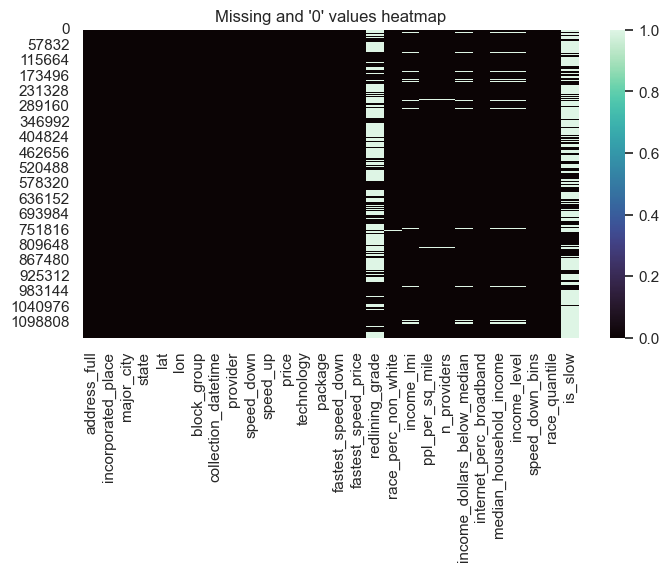


Duplicate  Value Count:   0


In [102]:
# plotting missing and 0 values
plt.figure(figsize=(8,4))
plt.title('Missing and \'0\' values heatmap')
sns.heatmap((isp_merged.isnull()) | (isp_merged == 0), cmap = 'mako')
plt.show()

print('\nDuplicate  Value Count:  ', isp_merged.duplicated().sum())

Variables with 0's or missing values that will be corrected in the following sections:

- `redlining_grade`
- `income_lmi`
- `ppl_per_sq_mile`
- `n_providers`
- `income_dollars_below_median`
- `median_household_income`
- `income_level`
- `race_perc_non_white` and
- `is_slow`

The `is_slow` variable is a special case because it's boolean and represents the answer of the question "Is the internet service advertised in this address slow?", but missing values there should be checked as well. There are no duplicate values.

#### 1.2.2 Data Clean: dropping the 0's

Rows equal to "0" will be dropped because they are a low percentage of the data.

In [103]:
#  percentage of 0's before dropping these rows
for i in ['redlining_grade', 'income_lmi', 'ppl_per_sq_mile', 'n_providers', 'income_dollars_below_median', 'median_household_income', 'income_level', 'race_perc_non_white']:
    cero_before = len(isp_merged[isp_merged[i] == 0])*100/len(isp_merged)
    print(' before: {:>30} == 0:  {:>8.4f}%'.format(i,cero_before))
 

 before:                redlining_grade == 0:    0.0000%
 before:                     income_lmi == 0:    0.0000%
 before:                ppl_per_sq_mile == 0:    0.0792%
 before:                    n_providers == 0:    0.0000%
 before:    income_dollars_below_median == 0:    0.0052%
 before:        median_household_income == 0:    0.0000%
 before:                   income_level == 0:    0.0000%
 before:            race_perc_non_white == 0:    0.3626%


In [104]:
#  dropping rows with 0's in "ppl_per_sq_mile", "income_dollars_below_median" and "race_perc_non_white" variables
len(isp_merged[isp_merged['ppl_per_sq_mile'] == 0].index)
isp_merged.drop(isp_merged[isp_merged['ppl_per_sq_mile'] == 0].index, inplace = True)
len(isp_merged[isp_merged['income_dollars_below_median'] == 0].index)
isp_merged.drop(isp_merged[isp_merged['income_dollars_below_median'] == 0].index, inplace = True)
len(isp_merged[isp_merged['race_perc_non_white'] == 0].index)
isp_merged.drop(isp_merged[isp_merged['race_perc_non_white'] == 0].index, inplace = True)

#  percentage of 0's for these variables after the drop
for i in ['ppl_per_sq_mile', 'income_dollars_below_median', 'race_perc_non_white']:
    cero_after = len(isp_merged[isp_merged[i] == 0])*100/len(isp_merged)
    print(' after:  {:>30} == 0:  {:>8.2f}%'.format(i,cero_after))

 after:                 ppl_per_sq_mile == 0:      0.00%
 after:     income_dollars_below_median == 0:      0.00%
 after:             race_perc_non_white == 0:      0.00%


#### 1.2.3 Data Clean: percentage of missing values and treatment

7 numerical variables with missing values will be treated by backfilling with the mean. The `redlining_grade` is an important categorical variable with considerable amount of missing values and should be treated according to any hypothesis stablished for a ML model. Similar case, but with low percentage of missing values, one can see with the categorical variable `income_level`.

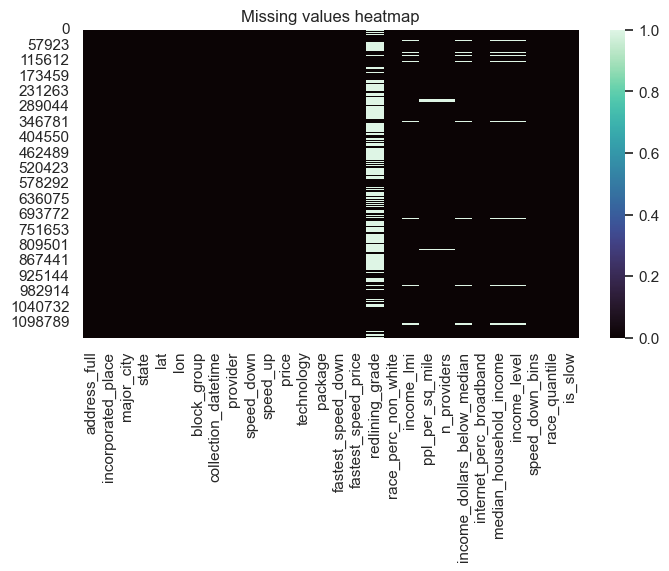

In [105]:
# plotting missing values
plt.figure(figsize=(8,4))
plt.title('Missing values heatmap')
sns.heatmap((isp_merged.isnull()), cmap = 'mako')
plt.show()

In [106]:
# percentage of missing values
total = isp_merged.isnull().sum().sort_values(ascending=False)
percent = 100*(isp_merged.isnull().sum()/len(isp_merged)).sort_values(ascending=False).round(4)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(9)

,Total,Percent
redlining_grade,639456,55.49
income_level,42726,3.71
median_household_income,42726,3.71
income_dollars_below_median,42726,3.71
income_lmi,42726,3.71
n_providers,13207,1.15
ppl_per_sq_mile,13205,1.15
internet_perc_broadband,375,0.03
address_full,0,0.00


In [107]:
# datatype of each variable with missing values
print("Boolean columns with missing values: " + str(isp_merged[isp_merged.columns[isp_merged.isnull().any()].tolist()].select_dtypes(include='bool').columns.tolist()))
print("Object columns with missing values: " + str(isp_merged[isp_merged.columns[isp_merged.isnull().any()].tolist()].select_dtypes(include='object').columns.tolist()))
print("Int64 columns with missing values: " + str(isp_merged[isp_merged.columns[isp_merged.isnull().any()].tolist()].select_dtypes(include='int64').columns.tolist()))
print("Float64 columns with missing values: " + str(isp_merged[isp_merged.columns[isp_merged.isnull().any()].tolist()].select_dtypes(include='float64').columns.tolist()))

Boolean columns with missing values: []
Object columns with missing values: ['redlining_grade', 'income_level']
Int64 columns with missing values: []
Float64 columns with missing values: ['income_lmi', 'ppl_per_sq_mile', 'n_providers', 'income_dollars_below_median', 'internet_perc_broadband', 'median_household_income']


In [108]:
# creating separate dataframes for treating numerical and categorical variables separately
numerical_columns = isp_merged.select_dtypes(include=['int64', 'float64'])
categorical_variables = isp_merged.select_dtypes(include=['object', 'bool'])

# imputation for numerical variables
my_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numerical_variables = pd.DataFrame(my_imputer.fit_transform(numerical_columns), columns=numerical_columns.columns, index=numerical_columns.index)

# joining the two dataframes back together
isp_data = pd.concat([numerical_variables, categorical_variables], axis=1)
print(isp_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152385 entries, 0 to 1156638
Data columns (total 28 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   lat                          1152385 non-null  float64
 1   lon                          1152385 non-null  float64
 2   block_group                  1152385 non-null  float64
 3   collection_datetime          1152385 non-null  float64
 4   speed_down                   1152385 non-null  float64
 5   speed_up                     1152385 non-null  float64
 6   price                        1152385 non-null  float64
 7   fastest_speed_down           1152385 non-null  float64
 8   fastest_speed_price          1152385 non-null  float64
 9   race_perc_non_white          1152385 non-null  float64
 10  income_lmi                   1152385 non-null  float64
 11  ppl_per_sq_mile              1152385 non-null  float64
 12  n_providers                  1152385 non-n

#### 1.3 Final Check

This is a final re-check for NULL and duplicate values in the dataset, except the 3 non-treated categorical variables.

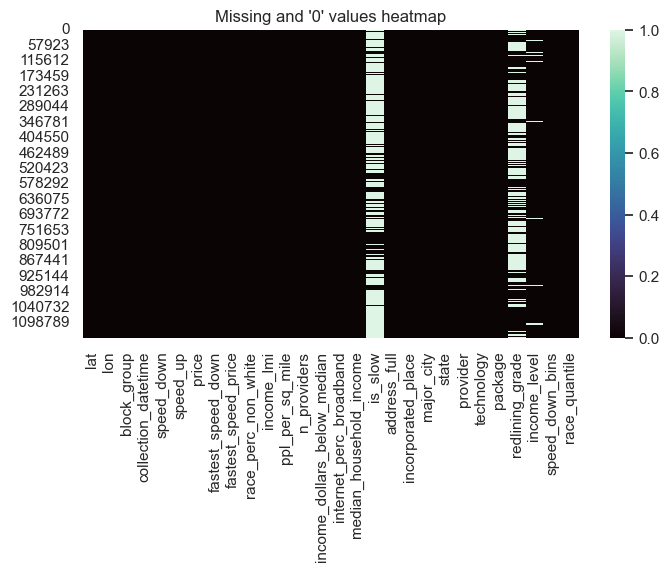


Duplicate  Value Count:   0


In [109]:
# plotting missing and 0 values
plt.figure(figsize=(8,4))
plt.title('Missing and \'0\' values heatmap')
sns.heatmap((isp_data.isnull()) | (isp_data == 0), cmap = 'mako')
plt.show()

print('\nDuplicate  Value Count:  ', isp_data.duplicated().sum())

In [110]:
# showing DataFrame info
isp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152385 entries, 0 to 1156638
Data columns (total 28 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   lat                          1152385 non-null  float64
 1   lon                          1152385 non-null  float64
 2   block_group                  1152385 non-null  float64
 3   collection_datetime          1152385 non-null  float64
 4   speed_down                   1152385 non-null  float64
 5   speed_up                     1152385 non-null  float64
 6   price                        1152385 non-null  float64
 7   fastest_speed_down           1152385 non-null  float64
 8   fastest_speed_price          1152385 non-null  float64
 9   race_perc_non_white          1152385 non-null  float64
 10  income_lmi                   1152385 non-null  float64
 11  ppl_per_sq_mile              1152385 non-null  float64
 12  n_providers                  1152385 non-n

In [111]:
# printing number of numerical and categorical variables and missing values
print('Number of features: {}'.format(isp_data.shape[1]))
print('Numerical features: {}'.format(isp_data.select_dtypes(['float','int']).shape[1]))
print('Categorical features: {}'.format(isp_data.select_dtypes(['object']).shape[1]))

Number of features: 28
Numerical features: 17
Categorical features: 11


### 1.4 Data Attributes

Dataset contains information about 28 features (17 numerical and 11 categorical) on 1,156,638 address-specific offers from 4 ISP's and is now ready for analysis.

| Column                        | Type        | Description                                                                                                                                     |
| :---                          | :---        | :---                                                                                                                                            |
| `lat`                         | Numerical   | The address’s latitude. From OpenAddresses or NYC Open Data.                                                                                    |
| `lon`                         | Numerical   | The address’s longitude. From OpenAddresses or NYC Open Data.                                                                                   |
| `block_group`                 | Numerical   | The Census block group of the address, as of 2019. From the Census Geocoder API based on `lat` and `lon`.                                       |
| `collection_datetime`         | Numerical   | The Unix timestamp that the address was used to query the provider's website.                                                                   |
| `speed_down`                  | Numerical   | Cheapest advertised download speed for the address.                                                                                             |
| `speed_up`                    | Numerical   | Cheapest advertised upload speed for the address.                                                                                               |
| `price`                       | Numerical   | The cost in USD of the cheapest advertised internet plan for the address.                                                                       |
| `fastest_speed_down`          | Numerical   | The advertised download speed of the fastest package. This is usually the same as the cheapest plan if the speed_down is less than 200 Mbps.    |
| `fastest_speed_price`         | Numerical   | The advertised upload speed of the fastest internet package for the address.                                                                    |
| `race_perc_non_white`         | Numerical   | The percentage of people of color (not non-Hispanic White) in the addresse's Census block group expressed as a proportion.                      |
| `income_lmi`                  | Numerical   | `median_household_income` divided by the city median household income.                                                                          |
| `ppl_per_sq_mile`             | Numerical   | People per square mile is used to determine population density.                                                                                 |
| `n_providers`                 | Numerical   | The number of other wired competitors in the addresses'.                                                                                        |
| `income_dollars_below_median` | Numerical   | City median household income minus the `median_household_income`.                                                                               |
| `internet_perc_broadband`     | Numerical   | The percentage of the population that is already subscripted to broadband in an addresses'.                                                      |
| `median_household_income`     | Numerical   | The median household income in the addresses' Census block group. Median Household Income in the past 12 months.                                |
| `is_slow`                     | Numerical   | A binary variable which is "1" if the address was offered a dowload speed under 25 Mbps and "0" otherwise.                                      |
| `address_full`                | Categorical | The complete postal address of a household we searched.                                                                                         |
| `incorporated_place`          | Categorical | The incorporated city that the address belongs to.                                                                                              |
| `major_city`                  | Categorical | The city that the address is in.                                                                                                                |
| `state`                       | Categorical | The state that the address is in.                                                                                                               |
| `provider`                    | Categorical | The internet service provider.                                                                                                                  |
| `technology`                  | Categorical | The kind of technology (fiber or non-fiber) used to serve the cheapest internet plan.                                                           |
| `package`                     | Categorical | The name of the cheapest internet plan.                                                                                                         |
| `redlining_grade`             | Categorical | The redlining grade, merged from Mapping Inequality based on the `lat` and `lon` of the adddress.                                               |
| `income_level`                | Categorical | Income-levels defined by the Community Reinvestment Act. Median household income from the 2019 5-year American Community Survey.<br /> The levels are: 'Low', 'Middle-Lower', 'Middle-Upper', 'Upper Income'.           |
| `speed_down_bins`             | Categorical | Speeds the ISPs say they provide in their offers classified as: Slow below 25Mbps, Medium between 25-100Mbps, Fast between 100-200Mbps <br /> and Blazing above 200Mbps.                  |
| `race_quantile`               | Categorical | Race and etnicity classification using quartiles ("Least White", "Less White","More White", "Most White"”") based on the percentage of residents <br /> identifying as non-Hispanic White in the address’s block group                                                                                                                                   |

## 2. Data Visualization (EDA)

### 2.1 Internet provider offers per city

Plot the amount of addresses-specific offers that every ISP's made to each city.

ISP Count:
 EarthLink      402185
AT&T           348611
Verizon        222301
CenturyLink    179288
Name: provider, dtype: int64


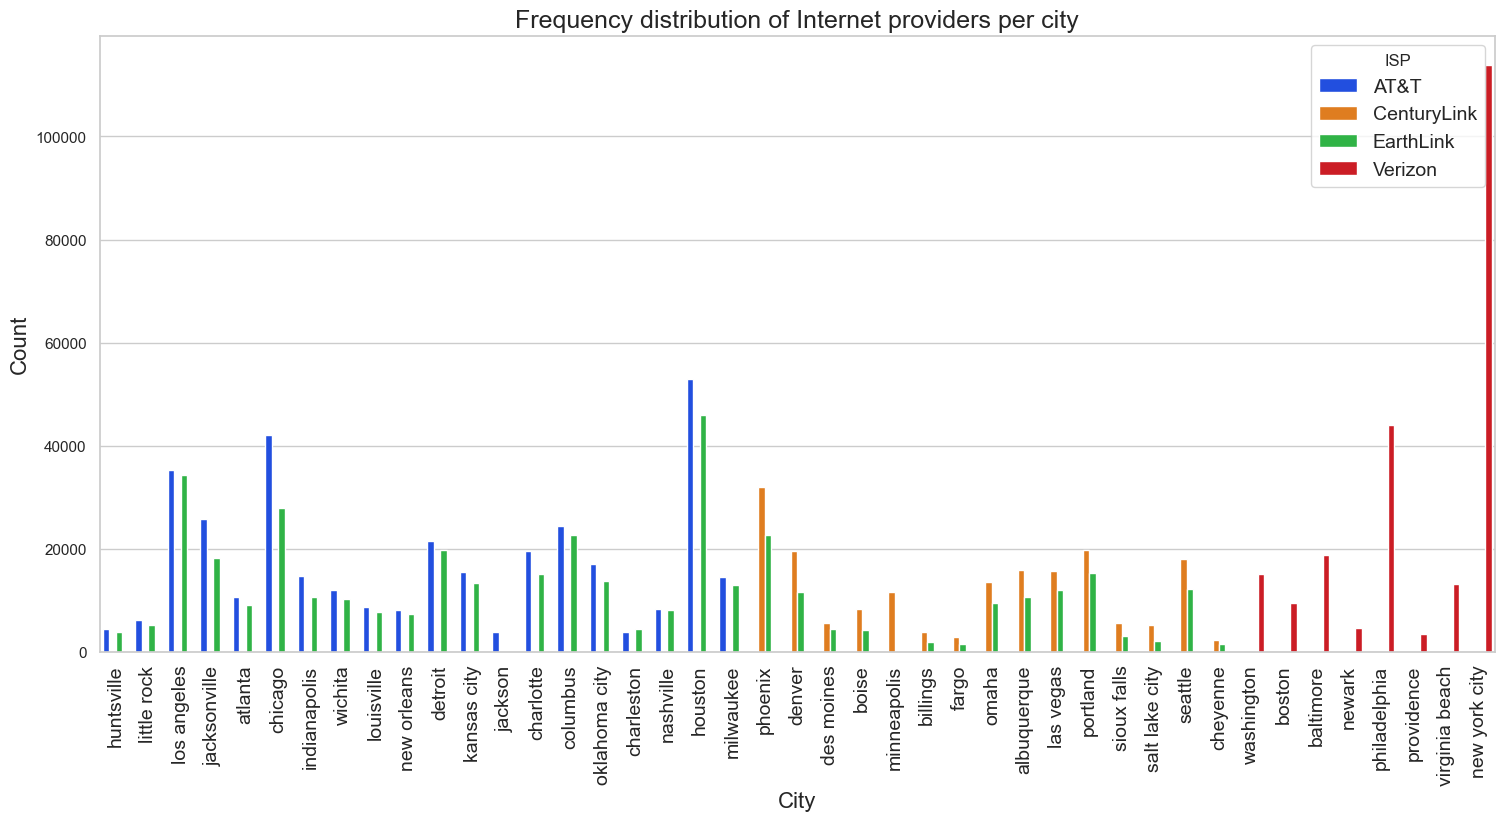

In [113]:
# distribution of internet provider per city
f, ax = plt.subplots(figsize=(18, 8))
ax = sns.countplot(x="major_city", hue="provider", data=isp_data, palette="bright")
ax.set_title("Frequency distribution of Internet providers per city", fontsize=18)
ax.set_xlabel("City", fontsize=16)
ax.set_ylabel("Count", fontsize=16)
plt.xticks(x="major_city", rotation='vertical', fontsize=14)
plt.legend(title= 'ISP', fontsize=14, loc='upper right')
print("ISP Count:\n",isp_data['provider'].value_counts())
plt.show()


- Earthlink seems to be the ISP with more cities where they offer their internet services. This company acts together with AT&T and Centurylink in several cities. However, the number of addresses contacted is lower than the other companies.
- There are 8 cities where Verizon is the only ISP offering services, and the only one with the highest number of offers in New York City.

### 2.2 Internet offers and slow speed service per provider

Plot the amount of addresses-specific offers made for every ISP's and the distribution of quality of service.

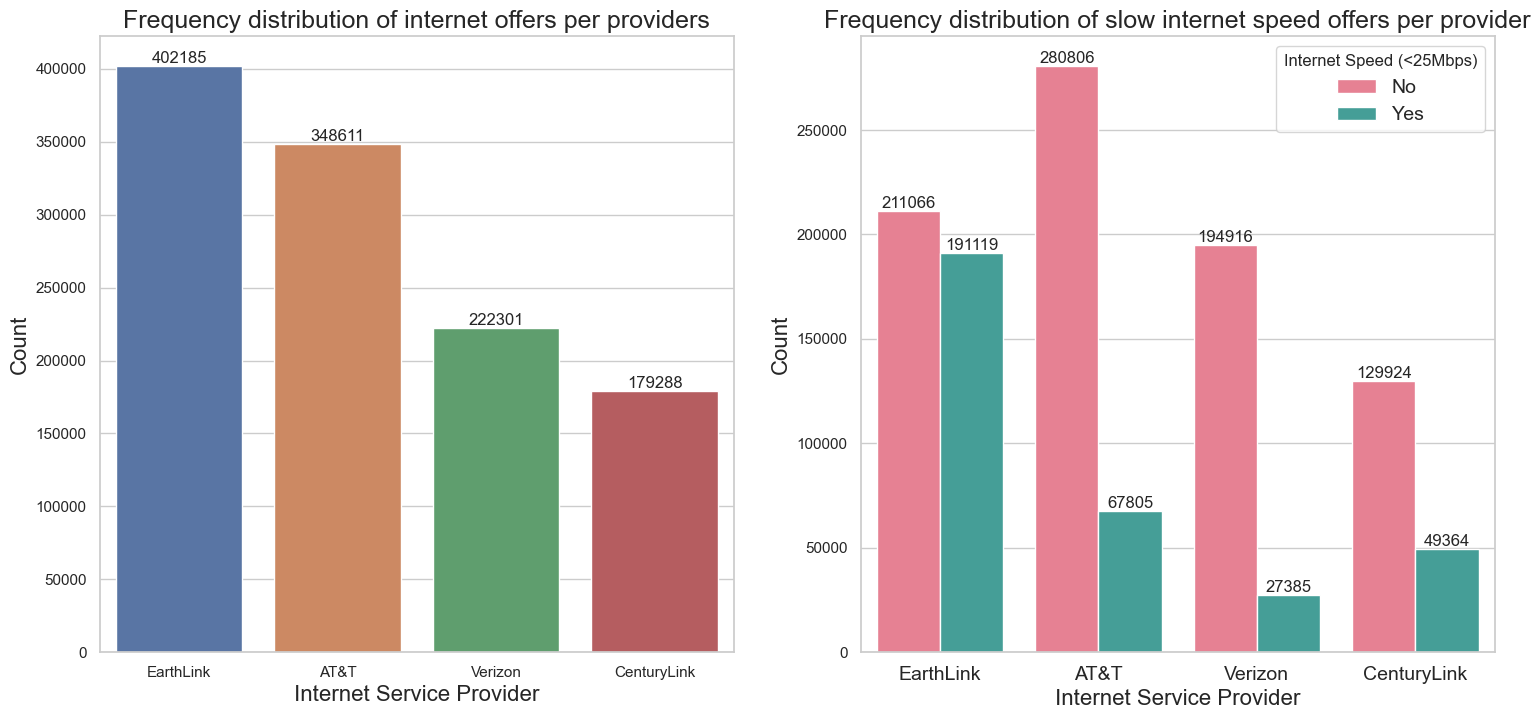

In [114]:
# distribution of internet offers and slow internet speed offers per provider
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))
ax[0] = sns.countplot(x="provider", data=isp_data,  order=['EarthLink', 'AT&T', 'Verizon', 'CenturyLink'], ax=ax[0])
# plotting counts in ax[0]
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.countplot(x="provider", hue="is_slow", data=isp_data, palette="husl", order=['EarthLink', 'AT&T', 'Verizon', 'CenturyLink'], ax=ax[1])
# plotting counts in ax[1]
for container in ax[1].containers:
    ax[1].bar_label(container)
ax[0].set_title("Frequency distribution of internet offers per providers", fontsize=18)
ax[0].set_xlabel("Internet Service Provider", fontsize=16)
ax[0].set_ylabel("Count", fontsize=16)
ax[1].set_title("Frequency distribution of slow internet speed offers per provider", fontsize=18)
ax[1].set_xlabel("Internet Service Provider", fontsize=16)
ax[1].set_ylabel("Count", fontsize=16)
plt.xticks(x="provider", fontsize=14)
plt.legend(labels = ['No', 'Yes'], title= 'Internet Speed (<25Mbps)', fontsize=14)
plt.show()


- The number of offers are lead by Earthlink and AT&T (~35% and ~30%), followed by Verizon and CenturyLink (~19% and ~16%). 
- The highest amount of non-slow (pink bar) internet speed offers is for AT&T and the lowest for CenturyLink.
- The highest amount of slow (green bar) internet speed offers is for EarthLink and the lowest for Verizon.
- ~29% of the offers are for slow (<25Mbps) internet speed, ~71% are Medium (25-100 Mbps), Fast (100-200 Mbps) and Blazing (>200Mbps) offers.
- EarthLink amount of offers are similar for good and bad service. 
- AT&T and EarthLink are the two companies that offer the most good internet service and cover most cities.

### 2.3 Internet download speed bins offers vs. prices

Plot the amount of addresses-specific offers per speed download bins: Slow, Medium, Fast and Blazing and compare them with the prices.

Price Count:
 55.00    348518
59.95    267139
39.99    222301
50.00    179287
49.95    114571
54.95     17973
69.95      2501
30.00        83
65.00         7
0.00          3
49.00         1
79.95         1
Name: price, dtype: int64


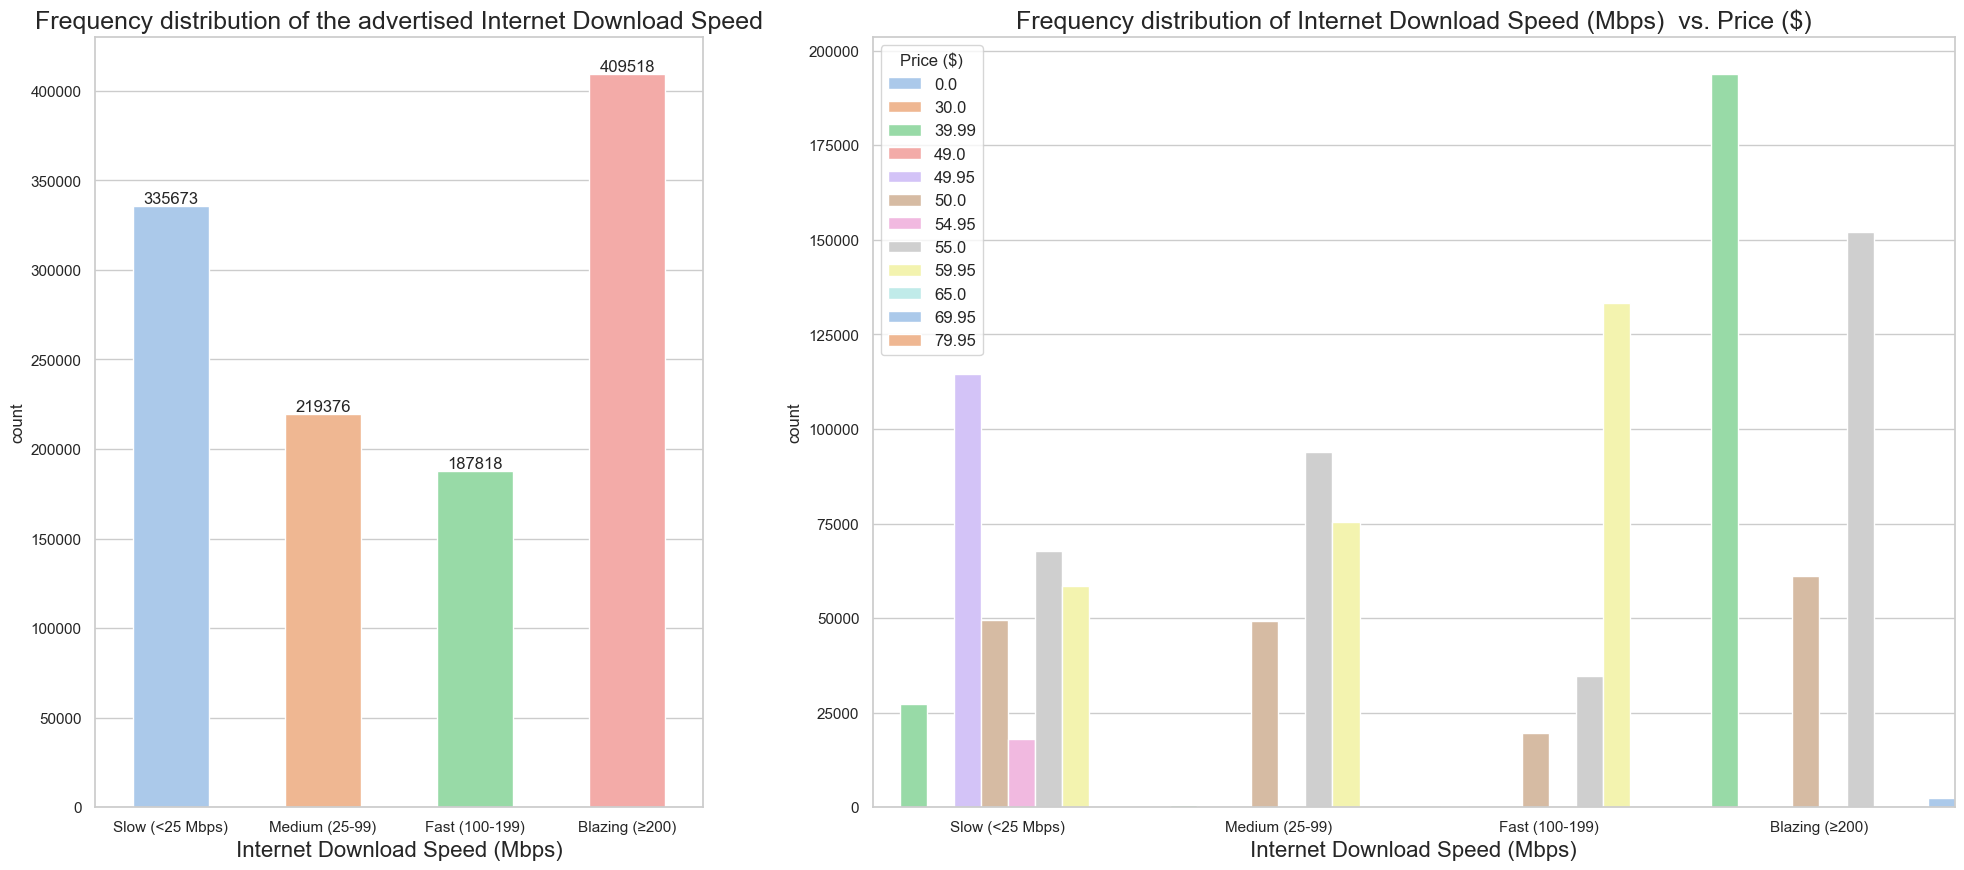

In [115]:
# distribution of frequency of internet download speed offers and prices
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 10), gridspec_kw={'width_ratios': [1.8, 3.2]})
ax[0] = sns.countplot(x="speed_down_bins", order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'],  data=isp_data, palette="pastel", ax=ax[0], width=0.5)

# plotting counts in ax[0]
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.countplot(x="speed_down_bins", hue="price", data=isp_data, palette="pastel", order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'],  ax=ax[1], width=1.2)
ax[0].set_title("Frequency distribution of the advertised Internet Download Speed", fontsize=18)
ax[0].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
ax[1].set_title("Frequency distribution of Internet Download Speed (Mbps)  vs. Price ($)",  fontsize=18)
ax[1].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
plt.xticks(x = "speed_down_bins")
plt.legend(title= 'Price ($)', loc='upper left', fontsize=12)
#checking how many offers where made per each price
print("Price Count:\n",isp_data['price'].value_counts())
plt.show()



Price Count:
 55.00    348518
59.95    267139
39.99    222301
50.00    179287
49.95    114571
54.95     17973
69.95      2501
Name: price, dtype: int64


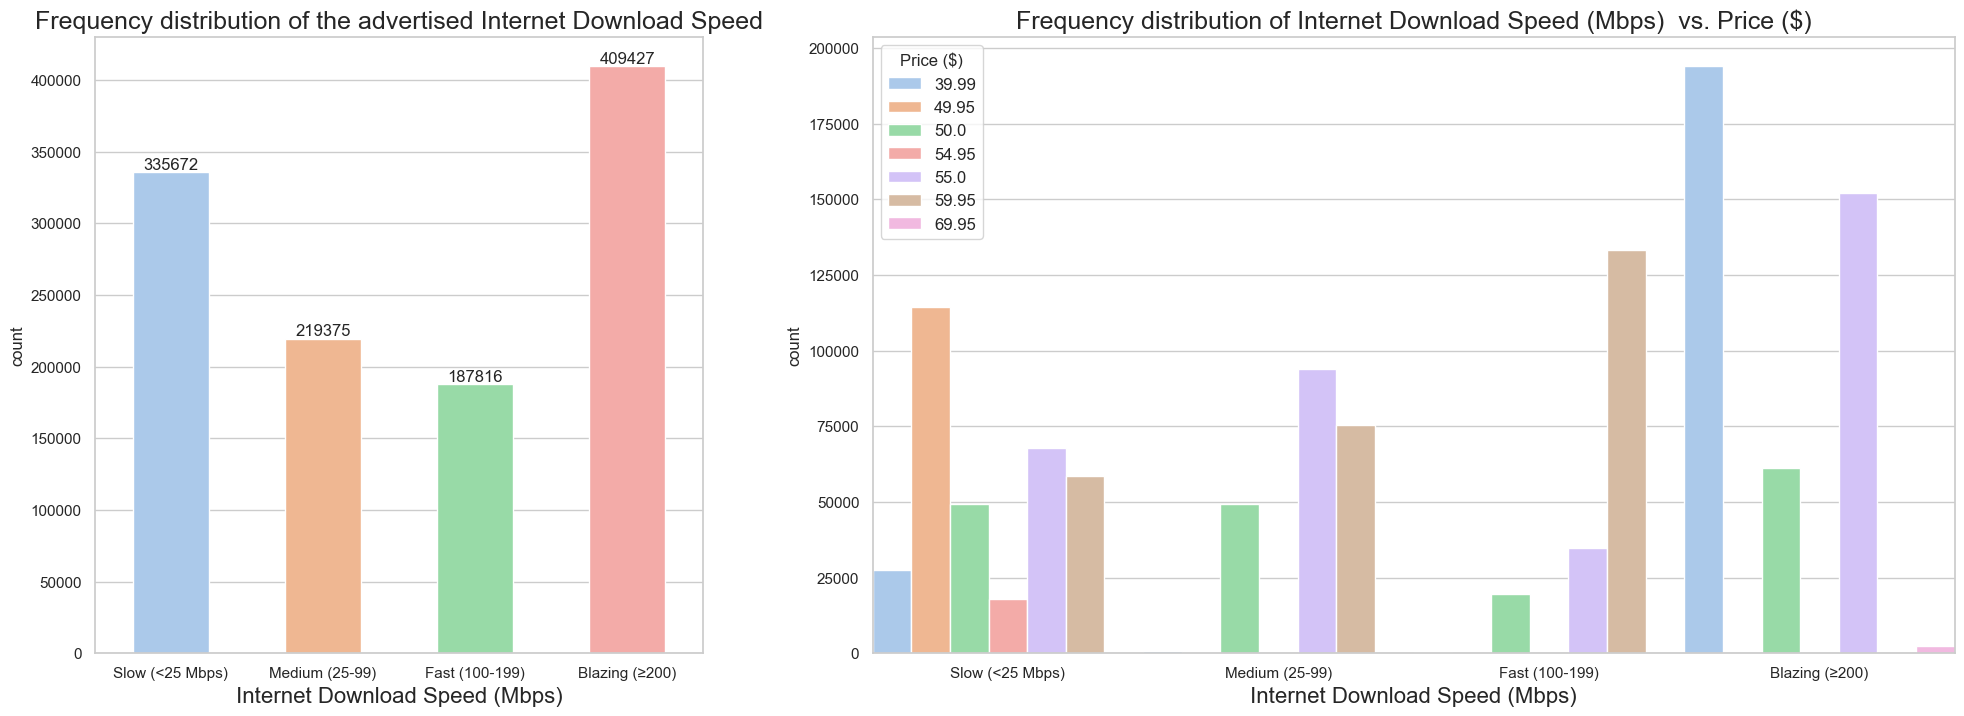

In [116]:
# distribution of frequency of internet download speed offers and prices after dropping few records in some price categories

# dropping few records in some price categories
isp_data.drop(isp_data[(isp_data['price'] == 65.00) | (isp_data['price'] == 0.0) | (isp_data['price'] == 49.0) | (isp_data['price'] == 79.95) | (isp_data['price'] == 30.00)].index, inplace = True)

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(24, 8), gridspec_kw={'width_ratios': [1.8, 3.2]})
ax[0] = sns.countplot(x="speed_down_bins", order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'],  data=isp_data, palette="pastel", ax=ax[0], width=0.5)
# plotting counts in ax[0]
for container in ax[0].containers:
    ax[0].bar_label(container)
ax[1] = sns.countplot(x="speed_down_bins", hue="price", data=isp_data, palette="pastel", order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'],  ax=ax[1], width=1)
ax[0].set_title("Frequency distribution of the advertised Internet Download Speed", fontsize=18)
ax[0].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
ax[1].set_title("Frequency distribution of Internet Download Speed (Mbps)  vs. Price ($)",  fontsize=18)
ax[1].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
plt.xticks(x = "speed_down_bins")
plt.legend(title= 'Price ($)', loc='upper left', fontsize=12)
print("Price Count:\n",isp_data['price'].value_counts())
plt.show()


- Most of the offers are concetrated between *Slow* and *Blazing* speeds.
- The *speed_down* variable is the cheapest advertised download speed. However, there is a range of prices between 39.99$ and 69.95$. 
- Prices for **Slow** download speed are between 39.99$ and 59.95$, and most of the offers fall into 49.95$ (orange bar).
- Prices for **Medium** and **Fast** download speed are between 50$ and 59.95$. The highest amount of **Medium** download speed offers fall into 55$ (purple bar), the highest amount of **Fast** download speed offers will pay 59.95$ (brown bar). 
- Prices for **Blazing** download speed offers are between 39.99$ and 69.95$ and most of the offers fall into 39.99$ (blue bar) followed by 55$ (purple bar).
- There's an evidence of disparities in prices according to download speeds, for example, one can pay 39.99$ and receive **Slow** or **Blazing** download speed service; on the other hand 49.95$ can be paid for a **Slow** speed download internet service.

### 2.4 Income household levels vs. internet plan prices

Plot the distribution of internet plan prices based on income level: 'Low', 'Middle-Lower', 'Middle-Upper', 'Upper Income'.

Income Count:
 Middle-Upper    277949
Low             277499
Middle-Lower    277148
Upper Income    276969
Name: income_level, dtype: int64


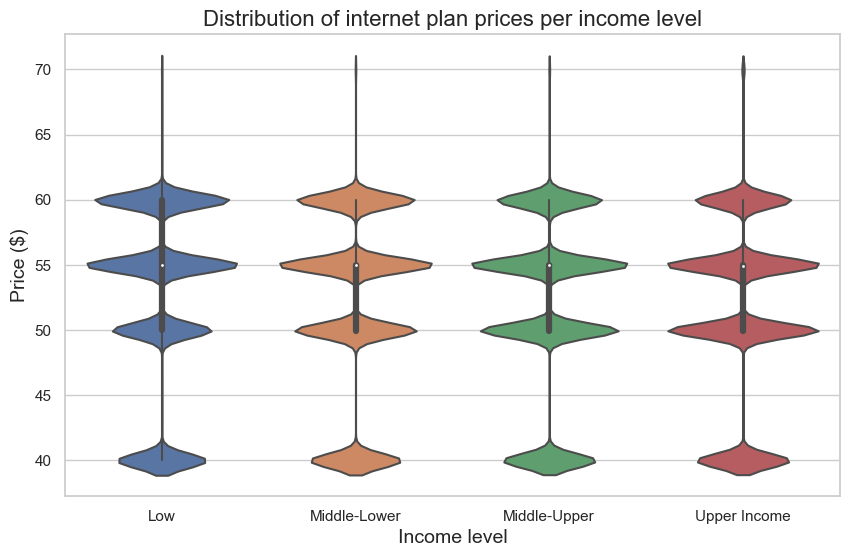

In [117]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=isp_data, x="income_level", y="price", order=['Low', 'Middle-Lower', 'Middle-Upper', 'Upper Income'])
ax.set_title("Distribution of internet plan prices per income level", fontsize=16)
ax.set_xlabel("Income level", fontsize=14)
ax.set_ylabel("Price ($)", fontsize=14)
print("Income Count:\n",isp_data['income_level'].value_counts())
plt.show()


According to the numbers it seems that for income level the mean price is 55 dollars, with few addresses down 40 dollars. The distribution in these bins seem to be equally distributed for each level.

### 2.5 Speed Down Bins vs. internet plan prices

Plot the distribution of internet plan prices based on speed down bins: 'Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'.

Speed Down Bins Count:
 Blazing (≥200)     409427
Slow (<25 Mbps)    335672
Medium (25-99)     219375
Fast (100-199)     187816
Name: speed_down_bins, dtype: int64


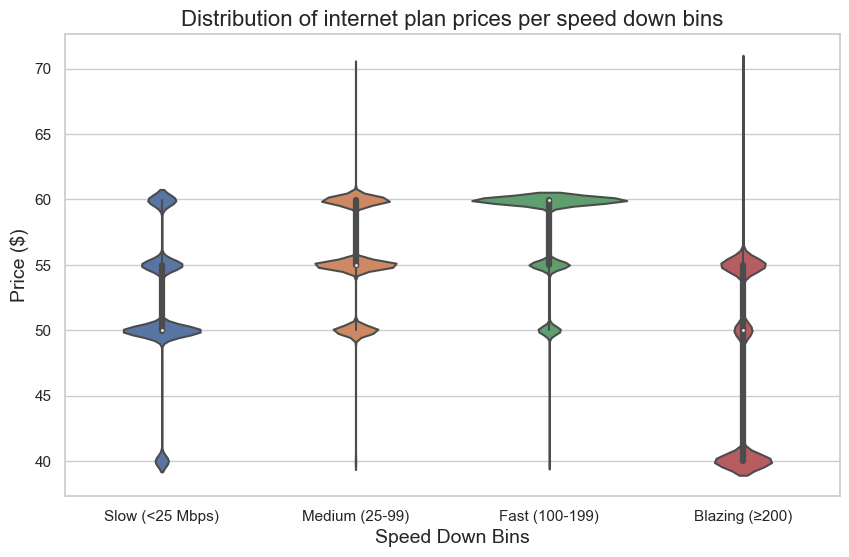

In [122]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(data=isp_data, x="speed_down_bins", y="price", order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'])
ax.set_title("Distribution of internet plan prices per speed down bins", fontsize=16)
ax.set_xlabel("Speed Down Bins", fontsize=14)
ax.set_ylabel("Price ($)", fontsize=14)
print("Speed Down Bins Count:\n",isp_data['speed_down_bins'].value_counts())
plt.show()

There is a huge difference in prices between speed down bins. The mean price for Medium and Fast speeds is 55 and 60 dollars, respectively. On the other hand, the mean price for Slow and Blazing speeds is 50 dollars, lot of offers of 40 dollars for Blazing speed and another lot of 50 dollars per Slow speed reveal a disparity in the offers. 

### 2.6 Internet download speed bins offers vs. income level and race quantile

Plot the amount of addresses-specific offers per income level and race quantile on each speed download bins: Slow, Medium, Fast and Blazing.

The quartile labeled “Least White” represents the greatest concentration of people of color in a city, whereas the quartile labeled “Most White” represents the greatest concentration of White people in the city.

Yhe Income Level is based on the median household income of an address’s block group. Quartiles were used to approximate the same number of addresses in each category. In cases when so many addresses carried the same value that they crossed a quartile boundary, the quartile boundary was moved to just below that value so that addresses with that value were assigned to only one quartile.

Income Level Count:
 Middle-Upper    277949
Low             277499
Middle-Lower    277148
Upper Income    276969
Name: income_level, dtype: int64

Race Quantile Count:
 more white     289778
less white     288375
least white    288253
most white     285884
Name: race_quantile, dtype: int64


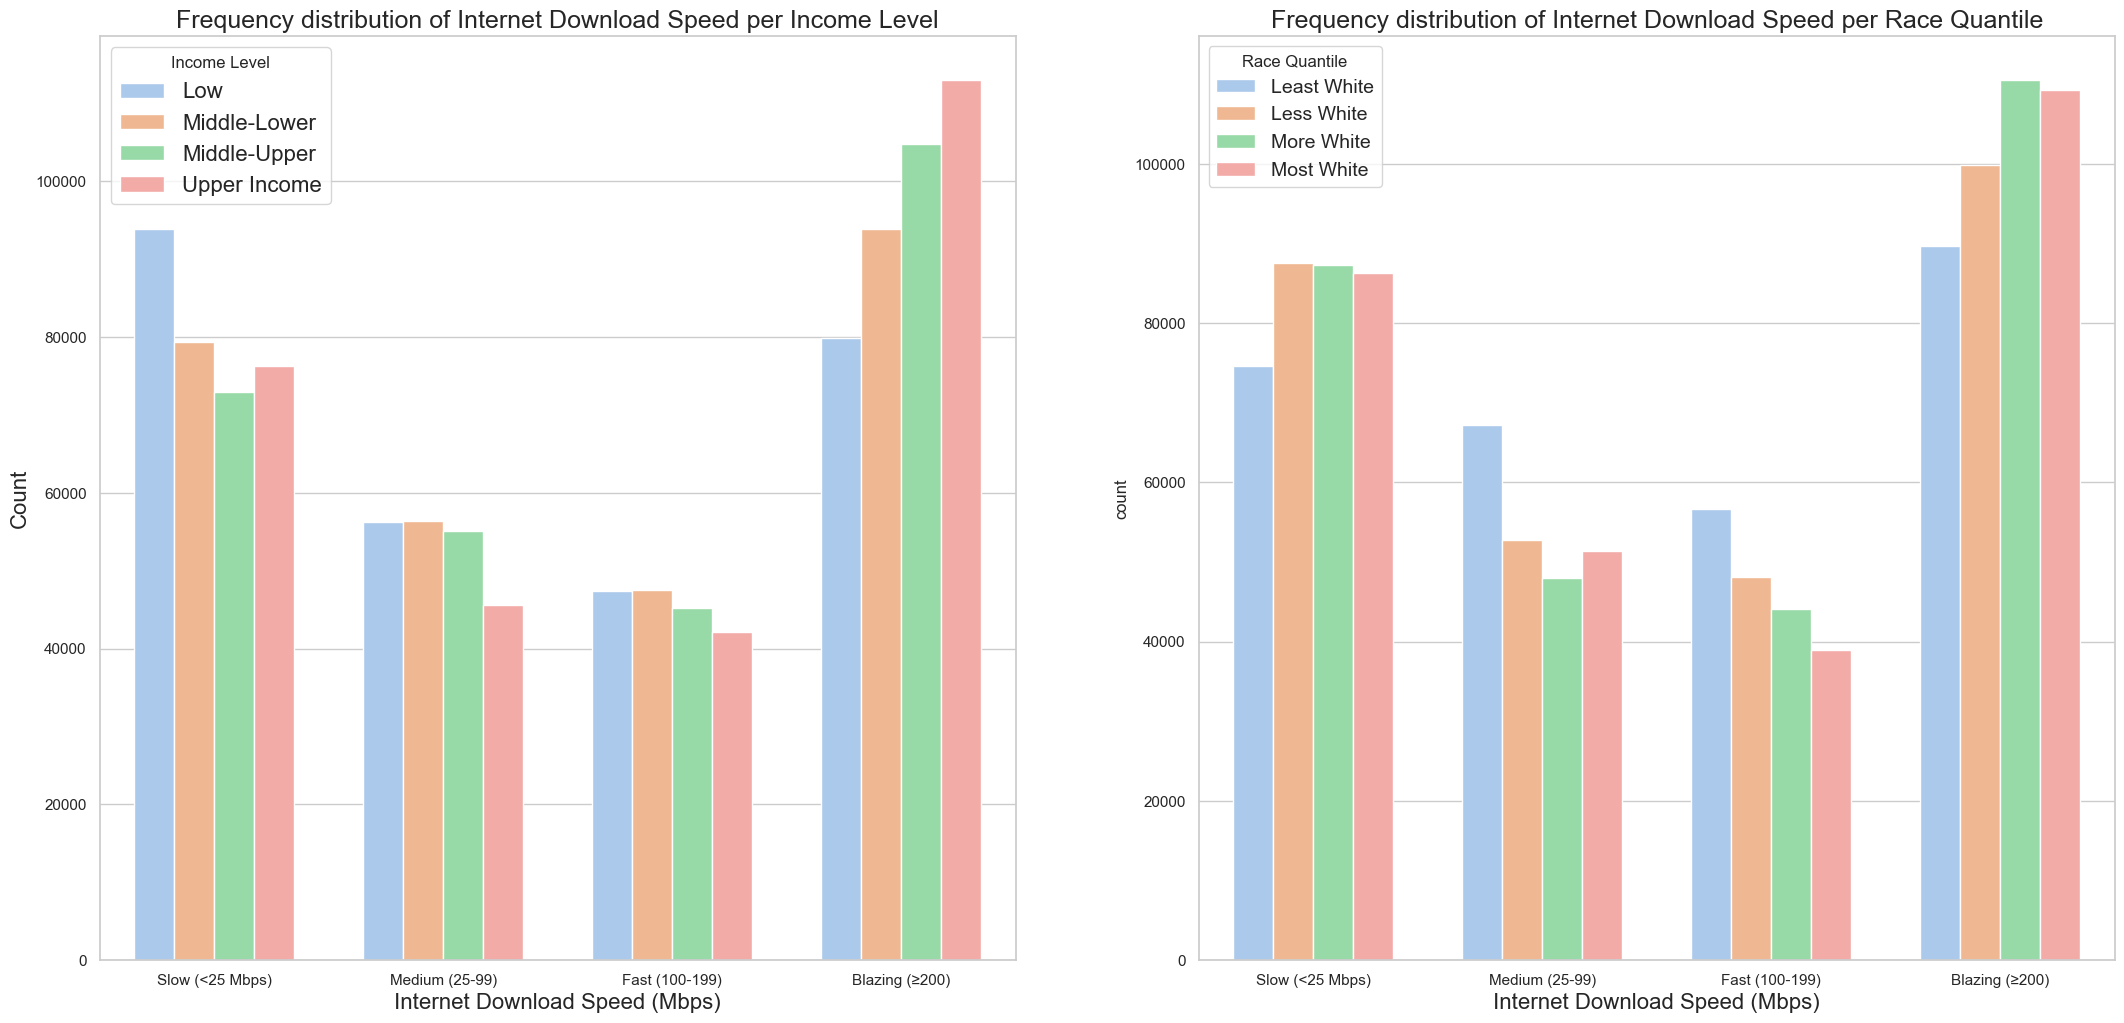

In [125]:
# distribution of frequency of internet download speed offers versus income level and race quantile
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(26, 12), gridspec_kw={'width_ratios': [2, 2]})
# fig 1
ax[0] = sns.countplot(x="speed_down_bins", hue="income_level",  hue_order=['Low', 'Middle-Lower', 'Middle-Upper', 'Upper Income'],  data=isp_data,  order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'], width=0.7, palette="pastel", ax=ax[0])
ax[0].legend(title= 'Income Level', fontsize=16, loc='upper left')
ax[0].set_title("Frequency distribution of Internet Download Speed per Income Level", fontsize=18)
ax[0].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
ax[0].set_ylabel("Count", fontsize=16)
# fig 2
ax[1] = sns.countplot(x="speed_down_bins", hue="race_quantile",  hue_order=['least white', 'less white', 'more white', 'most white'],  data=isp_data,  order=['Slow (<25 Mbps)', 'Medium (25-99)', 'Fast (100-199)', 'Blazing (≥200)'], width=0.7,palette="pastel", ax=ax[1])
ax[1].legend(title= 'Race Quantile', labels = ['Least White', 'Less White', 'More White',  'Most White'], fontsize=14, loc='upper left')
ax[1].set_title("Frequency distribution of Internet Download Speed per Race Quantile", fontsize=18)
ax[1].set_xlabel("Internet Download Speed (Mbps)", fontsize=16)
plt.xticks(x = "speed_down_bins")
# count on each category
print("Income Level Count:\n", isp_data['income_level'].value_counts())
print("")
print("Race Quantile Count:\n",isp_data['race_quantile'].value_counts())
plt.show()


- The proportion of people on each category (Income Level and Race Quantile) is more or less the same, with *Slow* and *Blazing* internet services being the most widely offered by ISPs.
- People with *Low* and *Middle-Low* income levels are being offered *Slow* and *Blazing* internet service in the same proportion. On the other hand, both color and white people receive roughly the same amount of *Slow* internet offers, while *Blazing* internet offers are higher for white people.
- The distribution of Income Level is more or less in the same proportion for *Medium* and *Fast* internet service, with the *Low*, *Middle-Lower*, *Least White* and *Less White* population receiving the most offers of these services. 
- There is a notorious disparitie in offers for the *Blazing* service, white people with high income level are those who benefit most from this offer.  


### 2.7 Average Median Household Income and Download Speed by State

A Chrorpleth map using different shading patterns or colors in predefined areas to represent geographic characteristics in relation to a variable or metric. In this case, plot the average median household income and download speed advertised per state in the U.S., then scatter plot both variables and check for correlation.

In [126]:
# preparing a DataFrame with the data to be plotted in the maps
mapisp = pd.DataFrame(columns =  ['State', 'Avg Median Household Income ($)', 'Avg Speed Down (Mbps)', 'Price ($)', 'Fastest Speed Down (Mbps)', 'Fastest Speed Price ($)', 'No. Providers', 'Provider'])
mapisp['State'] = isp_data['median_household_income'].groupby(isp_data['state']).mean().round(2).index
mapisp['Avg Median Household Income ($)'] = isp_data['median_household_income'].groupby(isp_data['state']).mean().round(2).values
mapisp['Avg Speed Down (Mbps)'] = isp_data['speed_down'].groupby(isp_data['state']).mean().round(2).values
mapisp['Price ($)'] = isp_data['price'].groupby(isp_data['state']).mean().round(2).values
mapisp['Fastest Speed Down (Mbps)'] = isp_data['fastest_speed_down'].groupby(isp_data['state']).mean().round(2).values
mapisp['Fastest Speed Price ($)'] = isp_data['fastest_speed_price'].groupby(isp_data['state']).mean().round(2).values
mapisp['No. Providers'] = isp_data['n_providers'].groupby(isp_data['state']).mean().round(2).values
mapisp['Provider'] = isp_data['provider'].groupby(isp_data['state']).count().values
mapisp['Avg Race Per Non-White (%)']= isp_data['race_perc_non_white'].groupby(isp_data['state']).mean().round(2).values

In [127]:
# map of Average Median Household Income by State AT&T
fig = px.choropleth(mapisp,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Avg Median Household Income ($)',
                    color_continuous_scale="geyser_r",
                    width=1000,
                    height=600
                  )
fig.update_layout(
      title_text = 'Average Median Household Income by State',
      title_font_family="Arial",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45 
                 )

fig.show()

In [128]:
# map of Average download speed by State AT&T
fig = px.choropleth(mapisp,
                    locations='State', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='Avg Speed Down (Mbps)',
                    color_continuous_scale="geyser_r",
                    width=1000,
                    height=600
                  )
fig.update_layout(
      title_text = 'Average Download Speed by State',
      title_font_family="Arial",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45 
                 )

fig.show()

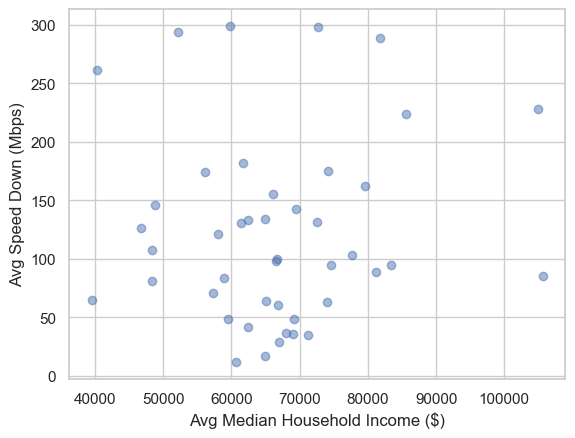

In [129]:
# correlation between Avg Median Household Income and Avg Speed Down
plt.scatter(x=mapisp['Avg Median Household Income ($)'], y=mapisp['Avg Speed Down (Mbps)'], alpha=0.5)
plt.xlabel('Avg Median Household Income ($)')
plt.ylabel('Avg Speed Down (Mbps)')
plt.show()

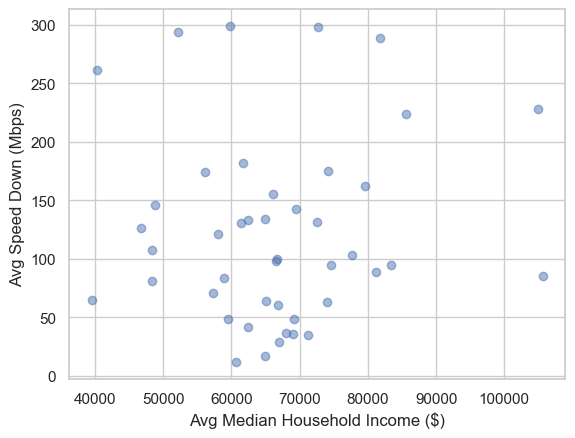

In [130]:
# correlation between Avg Median Household Income and Avg Speed Down
plt.scatter(x=mapisp['Avg Median Household Income ($)'], y=mapisp['Avg Speed Down (Mbps)'], alpha=0.5)
plt.xlabel('Avg Median Household Income ($)')
plt.ylabel('Avg Speed Down (Mbps)')
plt.show()

## 3. Explore interactions between variables (Correlations)

Correlation is a statistical metric for measuring to what extent different variables are interdependent.

In order to perform correlation, we need to first take care of two very important processes:

- Encoding categorical attributes with numerical values
- Normalization of the data

### 3.1 Encoding and Normalization

**Encoding**

Machine learning algorithms cannot process categorical or text data unless they have been converted to numbers. Encoding maps categorical values to integer values, which are represented as a binary vector that are all zero values, except the index of the integer, which is set to 1.

Categorical attributes will be manually encoded with numeric values. The steps involved are:

1. ``get_dummies()`` method for one-hot-encoding categorical variables.
2. Calculate cardinality (number of unique values in a column) to ensure the one-hot-encoding makes sense; as this method creates new (binary) columns indicating the presence of each possible value from the original data will be better to choose columns with less than 12 different values.
3. Encode with numerical values.

In [131]:
# checking cardinality in all categorical variables
categorical_columns = isp_data.select_dtypes(include=['object', 'bool'])

categorical_column_names = list(categorical_columns.columns)
for k in categorical_column_names:
    print(str(k) + ' = ' + str(categorical_columns[k].nunique()))
categorical_columns.head()

address_full = 1122253
incorporated_place = 43
major_city = 43
state = 44
provider = 4
technology = 5
package = 61
redlining_grade = 5
income_level = 4
speed_down_bins = 4
race_quantile = 4


,address_full,incorporated_place,major_city,state,provider,technology,package,redlining_grade,income_level,speed_down_bins,race_quantile
0,"2406 Country Club Ave NW, Huntsville AL 35816",Huntsville city,huntsville,AL,AT&T,Not Fiber,Internet Basic 768kbps,NaN,Low,Slow (<25 Mbps),more white
1,"1902 Oglesby Dr NW, Huntsville AL 35816",Huntsville city,huntsville,AL,AT&T,Not Fiber,Internet Basic 5,NaN,Low,Slow (<25 Mbps),more white
2,"2312 Cardinal Ave NW, Huntsville AL 35816",Huntsville city,huntsville,AL,AT&T,Not Fiber,Internet Basic 768kbps,NaN,Low,Slow (<25 Mbps),more white
3,"1903 Oglesby Dr NW, Huntsville AL 35816",Huntsville city,huntsville,AL,AT&T,Not Fiber,Internet Basic 5,NaN,Low,Slow (<25 Mbps),more white
4,"1905 Canterbury Cir NW, Huntsville AL 35816",Huntsville city,huntsville,AL,AT&T,Fiber,AT&T FIBER—INTERNET 300,NaN,Low,Blazing (≥200),more white


Variables with high cardinality (> 12 uniques values) can be dropped if they don't add any substancial info to the dataset or we can reduce cardinality by using an aggregation function. In this case:

- `address_full` = 1114359
- `incorporated_place` = 43
- `major_city` = 43
- `state` = 44
- `package` = 66

should be dropped and the rest can be one-hot-encoded. The special case of `redlining_grade` variable with 55.49% of missing values should be dropped as well, unless we find it interesting later for the investigation.

In [132]:
# dropping un-needed categorical columns from the original dataset "isp_data"
isp = isp_data.drop(['address_full', 'incorporated_place', 'major_city', 'state', 'package', 'redlining_grade'], axis=1)

In [133]:

# re-defining categorical variables
categorical_columns = isp.select_dtypes(include=['object', 'bool'])

In [134]:
# check for missing values in categorical variables
total = categorical_columns.isnull().sum().sort_values(ascending=False)
percent = 100*(categorical_columns.isnull().sum()/len(categorical_columns)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
income_level,42725,3.707834
provider,0,0.000000
technology,0,0.000000
speed_down_bins,0,0.000000
race_quantile,0,0.000000


The popular methods to handle the missing values for categorical variables in the dataset are as follows:

- Delete the observations.
- Replace missing values with the most frequent value.
- Develop a model to predict missing values.

In this case, as `income_level` has only a 3.7% of missing values we can choose the first method. Let's drop these 42,504 rows from the 'isp_data' dataset, and finally encode the categorical variables left.

In [135]:
# delete the missing observations in the "income_level" variable
isp.dropna(axis=0, inplace=True)

In [136]:
# printing DataFrame info
isp.info()
# checking unique indexes
print('Unique Indexes: ', isp.index.is_unique)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109565 entries, 0 to 1156638
Data columns (total 22 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   lat                          1109565 non-null  float64
 1   lon                          1109565 non-null  float64
 2   block_group                  1109565 non-null  float64
 3   collection_datetime          1109565 non-null  float64
 4   speed_down                   1109565 non-null  float64
 5   speed_up                     1109565 non-null  float64
 6   price                        1109565 non-null  float64
 7   fastest_speed_down           1109565 non-null  float64
 8   fastest_speed_price          1109565 non-null  float64
 9   race_perc_non_white          1109565 non-null  float64
 10  income_lmi                   1109565 non-null  float64
 11  ppl_per_sq_mile              1109565 non-null  float64
 12  n_providers                  1109565 non-n

In [137]:
# re-checking missing values in the DataFrame
total = isp.isnull().sum().sort_values(ascending=False)
percent = 100*(isp.isnull().sum()/len(isp)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
lat,0,0.0
lon,0,0.0
speed_down_bins,0,0.0
income_level,0,0.0
technology,0,0.0
provider,0,0.0
is_slow,0,0.0
median_household_income,0,0.0
internet_perc_broadband,0,0.0
income_dollars_below_median,0,0.0


In [138]:
# one-hot-encoding categorical variables
isp_df = pd.get_dummies(isp)
# printing new DataFrame info
isp_df.info()
# checking unique indexes
print('Unique Indexes: ', isp_df.index.is_unique)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109565 entries, 0 to 1156638
Data columns (total 38 columns):
 #   Column                           Non-Null Count    Dtype  
---  ------                           --------------    -----  
 0   lat                              1109565 non-null  float64
 1   lon                              1109565 non-null  float64
 2   block_group                      1109565 non-null  float64
 3   collection_datetime              1109565 non-null  float64
 4   speed_down                       1109565 non-null  float64
 5   speed_up                         1109565 non-null  float64
 6   price                            1109565 non-null  float64
 7   fastest_speed_down               1109565 non-null  float64
 8   fastest_speed_price              1109565 non-null  float64
 9   race_perc_non_white              1109565 non-null  float64
 10  income_lmi                       1109565 non-null  float64
 11  ppl_per_sq_mile                  1109565 non-null 

**Normalization**

Normalization is rescaling or adjusting values measured on different scales to a notionally common scale, typically on a range between 0 and 1. Normalized data is essential in Machine Learning. Correlation and models will not produce good results if the scales are not *standardized*.

Data in `isp_df` will be normalized and then updated with the encoded and normalized data.

In [139]:
# normalizing data 
isp_norm = MinMaxScaler().fit_transform(isp_df)
isp_df = pd.DataFrame(isp_norm, index = isp_df.index, columns = isp_df.columns)

Text(0.5, 1.0, 'ISP offers Correlation')

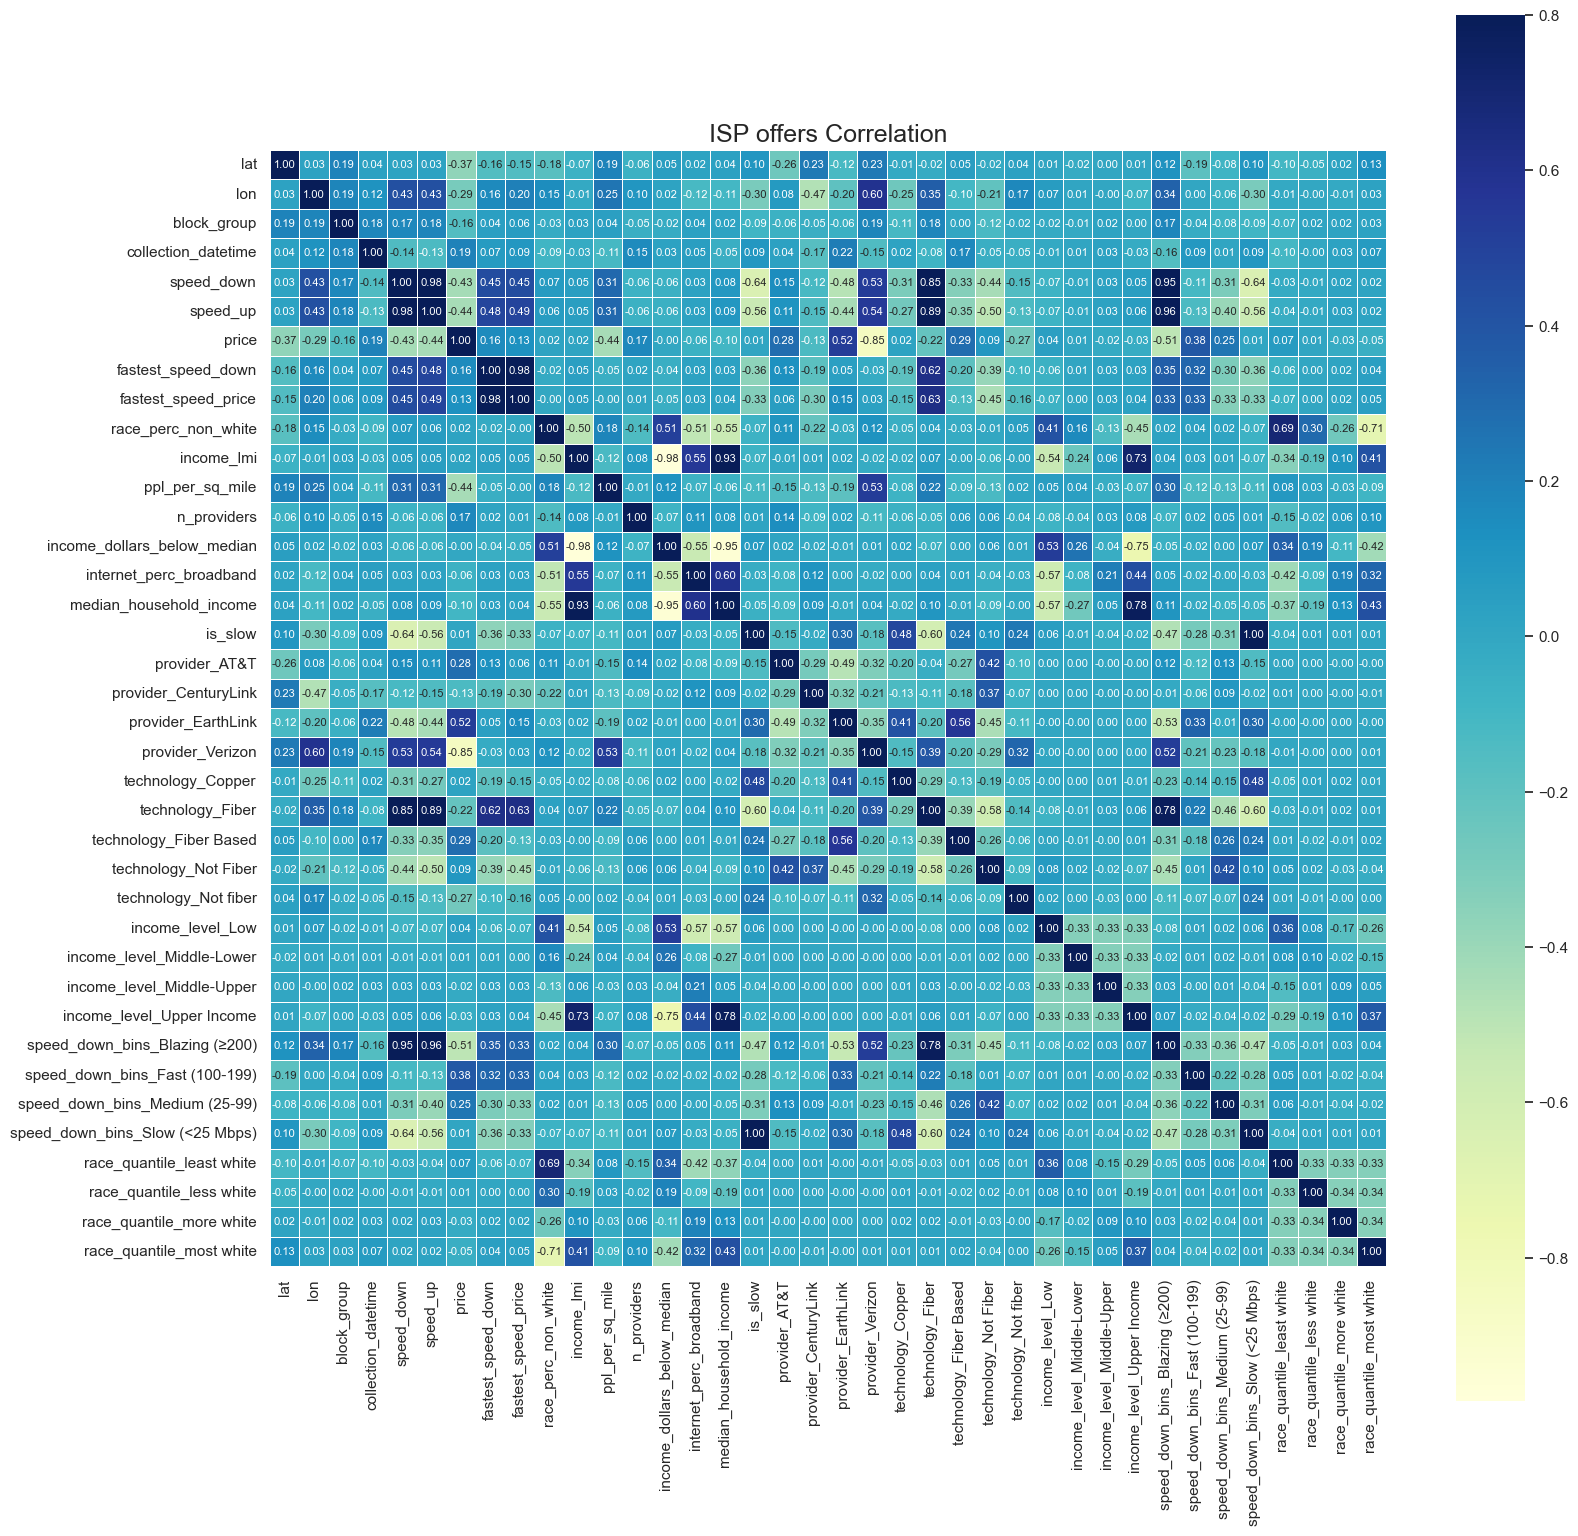

In [140]:
# correlation matrix
data_corr = isp_df.corr()

#kot = corrmat[corrmat>=.7]
f, ax=plt.subplots(figsize=(18,18))
sns.heatmap(data_corr, vmax=.8, square=True, cmap="YlGnBu", fmt='.2f',annot=True, linewidth=.5, annot_kws={'fontsize':8})
plt.title('ISP offers Correlation', fontsize=18)


The `speed_down` looks like an interesting target variable to be predicted in a Machine Learning model. `technology_fiber`, `provider_Verizone`, `ppl_per_sq_mile`, `fastest_speed_down`, `fastest_speed_price`, `speed_up` and `lon` are significant factors in determining the Internet Download Speed offers by the ISP's. `speed_down_bins_Blazing (≥200)` comes from `speed_down` and should be descarted. 

The next plot shows a zoom on `speed_down` and 15 selected variables and order by zthe correlation to `speed_down`.

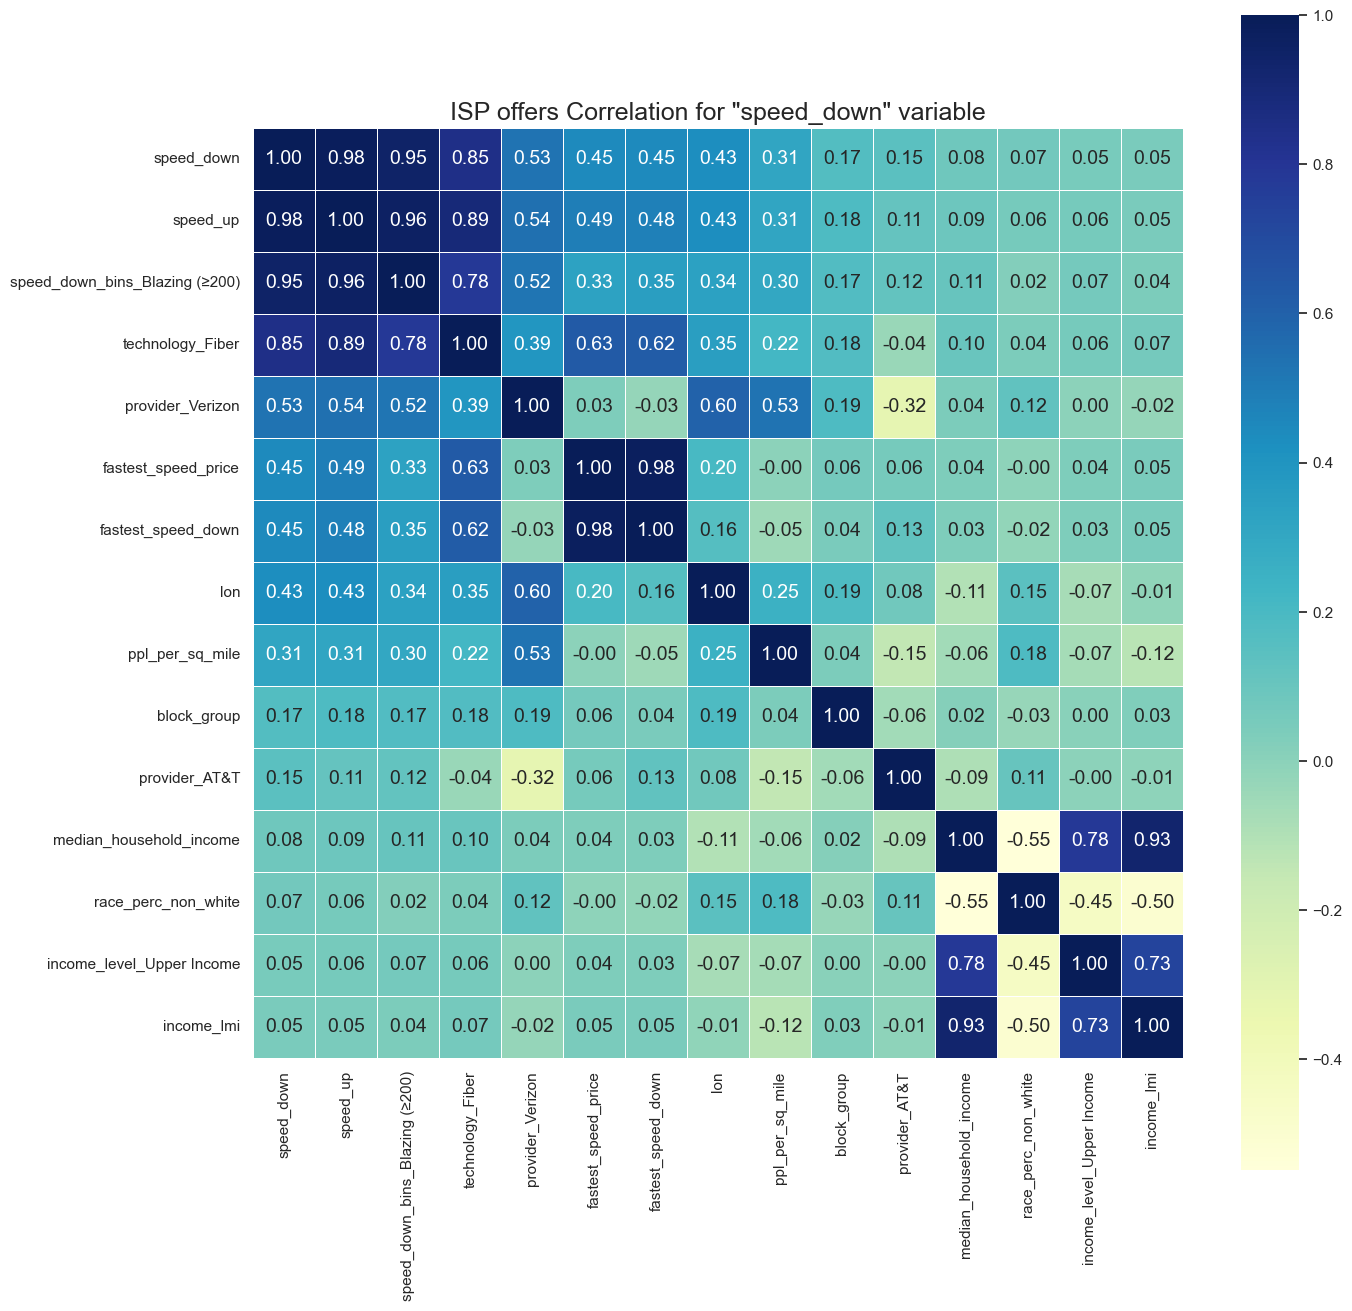

In [141]:
# speed_down correlation matrix zoom
k=15
f, ax=plt.subplots(figsize=(15,15))
cols=data_corr.nlargest(k, 'speed_down')['speed_down'].index
cm=np.corrcoef(isp_df[cols].values.T)
sns.set(font_scale=1)
hm=sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', linewidth=.5, annot_kws={'fontsize':14}, yticklabels=cols.values, xticklabels=cols.values, cmap="YlGnBu")
plt.title('ISP offers Correlation for "speed_down" variable', fontsize=18)
plt.show()

## 4. Discover modeling potential with Machine Learning